## Importing Libraries and dataset

In [476]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [477]:
!pip install pyts

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [478]:
import pandas as pd
import numpy as np
import pickle

from tqdm import tqdm


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import sklearn.metrics as metrics 
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, make_scorer

import seaborn as sns

from pyts.image import GramianAngularField
import matplotlib.pyplot as plt
import cv2
import os

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Flatten, concatenate, Input, Dropout, SimpleRNN, LSTM, Bidirectional,BatchNormalization,PReLU,ReLU,Reshape
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Conv1D,Conv2D,Add
from tensorflow.keras.layers import MaxPool1D, MaxPooling2D, UpSampling2D, GlobalAveragePooling2D, Multiply
from tensorflow.keras.optimizers import Adam


from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator


import sklearn.metrics as metrics 
from sklearn.metrics import confusion_matrix, classification_report

In [479]:
df1 = pd.read_csv("/content/drive/MyDrive/Project Elective/EEG_data.csv")

In [480]:
df1.head()

,SubjectID,VideoID,Attention,Mediation,Raw,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2,predefinedlabel,user-definedlabeln
0,0.0,0.0,56.0,43.0,278.0,301963.0,90612.0,33735.0,23991.0,27946.0,45097.0,33228.0,8293.0,0.0,0.0
1,0.0,0.0,40.0,35.0,-50.0,73787.0,28083.0,1439.0,2240.0,2746.0,3687.0,5293.0,2740.0,0.0,0.0
2,0.0,0.0,47.0,48.0,101.0,758353.0,383745.0,201999.0,62107.0,36293.0,130536.0,57243.0,25354.0,0.0,0.0
3,0.0,0.0,47.0,57.0,-5.0,2012240.0,129350.0,61236.0,17084.0,11488.0,62462.0,49960.0,33932.0,0.0,0.0
4,0.0,0.0,44.0,53.0,-8.0,1005145.0,354328.0,37102.0,88881.0,45307.0,99603.0,44790.0,29749.0,0.0,0.0


In [481]:
df2 = pd.read_csv("//content/drive/MyDrive/Project Elective/demographic_info.csv")

In [482]:
# df2.head()

## Preprocessing

### Rename column 'subject ID' in df2 to 'SubjectID' so that we can perform inner join.

In [483]:
df2 = df2.rename(columns = {'subject ID': 'SubjectID'})

### Perform Inner join

In [484]:
df = pd.merge(df1, df2, on='SubjectID', how='inner')

In [485]:

# df.shape

In [486]:
# df.head()

### Perform one-hot encoding for categorical values

In [487]:
df = pd.get_dummies(df)

In [488]:
# df.head()

## Generating gramian angular field

In [489]:
# COL = 'Alpha2'
# COL = 'Beta2'
# COL = 'Gamma2'
COL = 'Delta'
# COL = 'Theta'

In [490]:
df_new = df[['SubjectID', 'VideoID', COL, 'user-definedlabeln']]

In [491]:
df_new

,SubjectID,VideoID,Delta,user-definedlabeln
0,0.0,0.0,301963.0,0.0
1,0.0,0.0,73787.0,0.0
2,0.0,0.0,758353.0,0.0
3,0.0,0.0,2012240.0,0.0
4,0.0,0.0,1005145.0,0.0
...,...,...,...,...
12806,9.0,9.0,127574.0,0.0
12807,9.0,9.0,323061.0,0.0
12808,9.0,9.0,680989.0,0.0
12809,9.0,9.0,366269.0,0.0


In [492]:
Gasf_matrices = []
Gadf_matrices = []
Y = [] # Stores labels
im_size = 32

# # GASF = GramianAngularField(method='summation')
# # GADF = GramianAngularField(method='difference')

In [493]:
# def save_fig(path, matrix):
#     fig = plt.figure(figsize=(3, 3))
#     plt.imshow(matrix[0], cmap='rainbow', origin='lower')
#     plt.savefig(path)
#     plt.close(fig)

In [494]:
# def save_fig(path, matrix):
#   plt.imshow(matrix[0], cmap='gray')
#   plt.axis('off')
#   plt.savefig(path, bbox_inches='tight', pad_inches=0)

In [495]:
i=0
for s_id in tqdm(range(0,10)):
    for v_id in range(0,10):
        df_temp = df_new.loc[(df['VideoID'] == v_id) & (df['SubjectID'] == s_id)]
        x = df_temp[COL].values
        # X = []
        # X.append(x.tolist())
        X = x
        
        image_size = im_size
        gasf = GramianAngularField(image_size=image_size, method='summation')
        X_Gasf = gasf.fit_transform(X.reshape(1, -1))
        Gasf_matrices.append(X_Gasf[0])
        # save_fig('/content/drive/MyDrive/Project Elective/GASF/'+str(i)+'.png',X_Gasf)
        
        gadf = GramianAngularField(image_size=image_size, method='difference')
        X_Gadf = gadf.fit_transform(X.reshape(1, -1))
        Gadf_matrices.append(X_Gadf[0])
        # save_fig('/content/drive/MyDrive/Project Elective/GADF/'+str(i)+'.png',X_Gadf)
        
        Y.append(df_temp['user-definedlabeln'].values[0])
        i+=1

100%|██████████| 10/10 [00:00<00:00, 20.40it/s]


In [496]:
len(Y)

100

In [497]:
# plt.imshow(Gadf_matrices[0], cmap='rainbow', origin='lower')

In [498]:
# with open("/content/drive/MyDrive/Project Elective/labels.txt", "wb") as fp:   #Pickling
#     pickle.dump(Y, fp)

## Loading Images, labels and performing binary classification

### Dummy's

In [499]:
# with open("/content/drive/MyDrive/Project Elective/labels.txt", "rb") as fp:   # Unpickling
#     y = pickle.load(fp)

In [500]:
# len(y)

In [501]:
# if y==Y:
#   print("yes")

In [502]:
# plt.figure(figsize=(8, 8))
# plt.imshow(Gasf_matrices[1][0], cmap='rainbow', origin='lower')
# plt.title("GASF", fontsize=16)
# plt.savefig('/kaggle/working/temp.png')

In [503]:
# def load_images_from_folder(folder):
#     images = []
#     targets = []
#     for filename in os.listdir(folder):
#         # print(filename, filename[:-4], int(filename[:-4]))
#         targets.append(y[int(filename[:-4])])
#         img = cv2.imread(os.path.join(folder,filename))
#         if img is not None:
#             images.append(img)
#     return images, targets

# images, targets = load_images_from_folder('/content/drive/MyDrive/Project Elective/GASF')

In [504]:
# print(len(targets))
# len(images)

In [505]:
# print(images[20].shape)
# plt.imshow(images[0])

In [506]:
# images[0].shape

In [507]:
# imgs = np.array(images)
# tars = np.array(targets)

### Train-TestSplit 80-20%

In [508]:

matrices = np.array(Gasf_matrices)
targets = np.array(Y)

In [509]:
print(type(matrices))

<class 'numpy.ndarray'>


In [510]:
matrices.shape

(100, 32, 32)

In [511]:
matrices = matrices.reshape((100,im_size,im_size,1))

In [512]:
matrices.shape

(100, 32, 32, 1)

In [513]:
# x_train,x_test,y_train,y_test = train_test_split(imgs,tars,test_size=0.20,random_state=42)


x_train,x_test,y_train,y_test = train_test_split(matrices,targets,test_size=0.20,random_state=42)

In [514]:
# x_train_np = x_train.to_numpy()
# len(x_train)

### Convolution Neural Network

#### GASF NETWORK


In [516]:
# gasf_model = models.Sequential()

# gasf_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(im_size, im_size, 1)))
# gasf_model.add(MaxPooling2D(pool_size=(2, 2)))
# gasf_model.add(Dropout(0.25))

# gasf_model.add(Conv2D(64, (3,3), activation='relu'))
# gasf_model.add(MaxPooling2D(pool_size=(2, 2)))
# gasf_model.add(Dropout(0.2))

# gasf_model.add(Flatten())

# gasf_model.add(Dense(64, activation='relu'))
# gasf_model.add(Dropout(0.5))
# gasf_model.add(Dense(1, activation='sigmoid'))

# gasf_model.summary()

#### Train Model

In [519]:
def train_model(model,x_train, y_train,x_test,y_test, save_to, epoch = 2):

        opt_adam = keras.optimizers.Adam(learning_rate=0.001)

        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
        mc = ModelCheckpoint('/content/drive/MyDrive/Project Elective/cnn_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
#         lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 0.001 * np.exp(-epoch / 10.))
        
        # model.compile(optimizer=opt_adam,loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),metrics=['accuracy'])
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        
        history = model.fit(x_train,y_train,
#                           batch_size=20,
                            epochs=epoch,
                            verbose=2,
                            # batch_size = 32,
                            validation_data=(x_test,y_test),
                            # callbacks=[es,mc])
                            callbacks=[mc])

        
        
        # saved_model = load_model(save_to + '_best_model.h5')
        
        return history, model

In [520]:
# history, model = train_model(gasf_model, x_train, y_train,x_test,y_test, save_to= './', epoch = 100) 

In [521]:
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

acc_per_fold = []
loss_per_fold = []
true_labels = []
pred_labels = []
pred_probs = []

fold_no = 1

In [522]:
# for train, test in kfold.split(matrices,targets):
#   print(targets[train])
#   print("\n")
#   print(targets[test])
#   print("****************************\n")

In [523]:
for train, test in kfold.split(matrices,targets): 
  # if fold_no!=1:
  # pass_model = gasf_model


  # *********** GAF Model ***********
  pass_model = models.Sequential()

  pass_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(im_size, im_size, 1)))
  pass_model.add(MaxPooling2D(pool_size=(2, 2)))
  pass_model.add(Dropout(0.25))

  pass_model.add(Conv2D(64, (3,3), activation='relu'))
  pass_model.add(MaxPooling2D(pool_size=(2, 2)))
  pass_model.add(Dropout(0.2))

  pass_model.add(Flatten())

  pass_model.add(Dense(64, activation='relu'))
  pass_model.add(Dropout(0.5))
  pass_model.add(Dense(1, activation='sigmoid'))
  # *********** GAF Model ***********



  history, model = train_model(pass_model, matrices[train], targets[train], matrices[test], targets[test], save_to= './', epoch = 50) 

  model = load_model('/content/drive/MyDrive/Project Elective/cnn_model.h5')

  scores = model.evaluate(matrices[test], targets[test], verbose=0)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  #   print("***************************************************\n")
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  y_pred = model.predict(matrices[test])
  pred_probs.extend(y_pred)
  y_hat = np.array(y_pred >= 0.5, dtype = int)
  true_labels.extend(targets[test])
  pred_labels.extend(y_hat)

  # Increase fold number
  fold_no = fold_no + 1

Epoch 1/50

Epoch 1: val_accuracy improved from -inf to 0.80000, saving model to /content/drive/MyDrive/Project Elective/cnn_model.h5
3/3 - 3s - loss: 0.7120 - accuracy: 0.4778 - val_loss: 0.6383 - val_accuracy: 0.8000 - 3s/epoch - 850ms/step
Epoch 2/50

Epoch 2: val_accuracy did not improve from 0.80000
3/3 - 0s - loss: 0.7405 - accuracy: 0.4000 - val_loss: 0.6751 - val_accuracy: 0.7000 - 143ms/epoch - 48ms/step
Epoch 3/50

Epoch 3: val_accuracy did not improve from 0.80000
3/3 - 0s - loss: 0.6952 - accuracy: 0.5222 - val_loss: 0.6764 - val_accuracy: 0.6000 - 165ms/epoch - 55ms/step
Epoch 4/50

Epoch 4: val_accuracy did not improve from 0.80000
3/3 - 0s - loss: 0.6640 - accuracy: 0.5889 - val_loss: 0.6431 - val_accuracy: 0.8000 - 140ms/epoch - 47ms/step
Epoch 5/50

Epoch 5: val_accuracy did not improve from 0.80000
3/3 - 0s - loss: 0.6587 - accuracy: 0.6444 - val_loss: 0.6328 - val_accuracy: 0.8000 - 144ms/epoch - 48ms/step
Epoch 6/50

Epoch 6: val_accuracy improved from 0.80000 to 0.

In [524]:
print(acc_per_fold)

[89.99999761581421, 89.99999761581421, 89.99999761581421, 69.9999988079071, 89.99999761581421, 80.0000011920929, 69.9999988079071, 89.99999761581421, 89.99999761581421, 69.9999988079071]


In [525]:
np.mean(acc_per_fold)

82.99999833106995

In [526]:
print("******" + COL + "******")

******Delta******


In [527]:
print(classification_report(true_labels, pred_labels))

              precision    recall  f1-score   support

         0.0       0.88      0.76      0.81        49
         1.0       0.79      0.90      0.84        51

    accuracy                           0.83       100
   macro avg       0.84      0.83      0.83       100
weighted avg       0.84      0.83      0.83       100



In [528]:
metrics.roc_auc_score(true_labels, pred_probs)

0.791516606642657

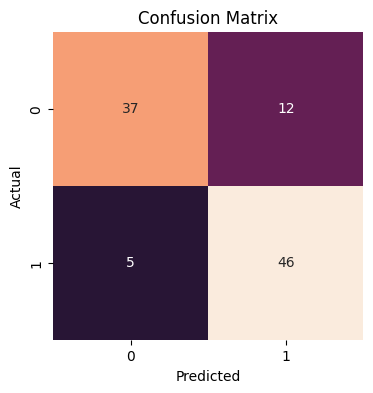

In [529]:
cm = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(4, 4))

sns.heatmap(cm, annot=True, fmt='g', vmin=0, cbar=False)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

plt.show()